Conclusion: ElasticNet was the best model with an r squared score of 87.5% on the test set. 

# Import DataFrame and Prep Model

In [0]:
#Arrays and Dataframe
import numpy as np
import pandas as pd

#SQL
from sqlalchemy import create_engine

#Visualization
from matplotlib import pyplot as plt
import seaborn as sns
sns.set()
import pylab

# Display preferences.
%matplotlib inline
pd.options.display.float_format = '{:.3f}'.format # can choose the number of decimal points to see

#Data Outliers
from scipy.stats.mstats import winsorize
from sklearn.preprocessing import QuantileTransformer

#Data Normilization and Scaling
from scipy.stats import boxcox
from sklearn.preprocessing import normalize
from sklearn.preprocessing import scale
from sklearn.preprocessing import StandardScaler

#Data Exploration
from wordcloud import WordCloud #may have to do pip install wordcloud from terminal
from scipy.stats import jarque_bera
from scipy.stats import normaltest
from scipy import stats
from scipy.stats import zscore
import math

#Feature Selection
from sklearn.decomposition import PCA
# from matplotlib.mlab import PCA as mlabPCA

#Data Modeling
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.svm import LinearSVC
import statsmodels.api as sm #may need to run pip install statsmodels

#Model Metrics
from sklearn.utils.multiclass import unique_labels
import itertools
from sklearn.metrics import mean_absolute_error
from statsmodels.tools.eval_measures import mse, rmse

#Testing model assumptions
from scipy.stats import bartlett
from scipy.stats import levene
from statsmodels.stats.outliers_influence import variance_inflation_factor 
from statsmodels.tools.tools import add_constant
from scipy.stats import jarque_bera
from scipy.stats import normaltest
from statsmodels.tsa.stattools import acf

#Overfitting Linear Models
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet

In [0]:
#Make SQL Queary
postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'houseprices'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))

df = pd.read_sql_query('select * from houseprices',con=engine)

# no need for an open connection, as we're only doing a single query
engine.dispose()

In [0]:
#Drop columns that have a large number of null values (over 30%) or are meaningless
df1 = df.drop(columns = ['alley', 'fireplacequ', 'poolqc', 'fence', 'miscfeature', 'id', 'lotshape', 'landcontour', 'lotconfig', 'condition1', 'condition2', 'roofstyle', 'roofmatl', 'heating', 'heatingqc', 'garagequal', 'paveddrive'])

In [0]:
#make a copy of df1
df2 = df1.copy()

#interpolate based on the year
year_list = list(df1['yearbuilt'].unique())
for year in year_list:
    df2.loc[df1['yearbuilt']==year] = df2.loc[df1['yearbuilt']==year].interpolate()

# drop missing values that are remaining
df2.dropna(inplace = True)

In [0]:
#update data types
non_numeric = df2.select_dtypes(include = 'object')
numeric = df2.select_dtypes(include = ['float64', 'int64'])

#one hot endoding to non_numeric
non_numeric = pd.get_dummies(non_numeric, drop_first = True)

In [0]:
#join back dataframes
df3 = pd.concat([numeric, non_numeric], axis = 1)

# Model 1

In [217]:
#Separate target variable from rest of data
X = df3.drop(columns = 'saleprice')
y = df3['saleprice']
X = sm.add_constant(X)

#split train_test
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [218]:
results = sm.OLS(y_train, X_train).fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              saleprice   R-squared:                       0.884
Model:                            OLS   Adj. R-squared:                  0.860
Method:                 Least Squares   F-statistic:                     36.44
Date:                Wed, 06 Nov 2019   Prob (F-statistic):          1.53e-290
Time:                        20:27:28   Log-Likelihood:                -11498.
No. Observations:                 988   AIC:                         2.334e+04
Df Residuals:                     816   BIC:                         2.418e+04
Df Model:                         171                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                  1.839e+06   1.71e+06      1.078      0.282   -1.51e+06    5.19e+06
mssubclass             -115.8178    128.256     -0.903      0.367    -367.569     135.933
lotfrontage            -179.3920     58.194     -3.083      0.002    -293.619     -65.165
lotarea                   0.6519      0.155      4.215      0.000       0.348       0.956
overallqual            9509.9003   1668.372      5.700      0.000    6235.093    1.28e+04
overallcond            5362.4809   1436.349      3.733      0.000    2543.107    8181.854
yearbuilt               113.4515    129.391      0.877      0.381    -140.528     367.431
yearremodadd             91.9192     93.331      0.985      0.325     -91.279     275.117
masvnrarea               15.0871      8.789      1.717      0.086      -2.165      32.339
bsmtfinsf1              -11.2397      4.445     -2.529      0.012     -19.964      -2.515
bsmtfinsf2                0.6607      9.525      0.069      0.945     -18.036      19.357
bsmtunfsf                 1.1331      4.496      0.252      0.801      -7.692       9.958
totalbsmtsf              -9.4457      6.256     -1.510      0.131     -21.725       2.834
firstflrsf               16.0964     12.246      1.314      0.189      -7.940      40.133
secondflrsf              31.9082     10.536      3.028      0.003      11.227      52.590
lowqualfinsf            -16.3281     29.192     -0.559      0.576     -73.628      40.971
grlivarea                31.6764     11.044      2.868      0.004       9.998      53.355
bsmtfullbath           1.116e+04   3135.287      3.559      0.000    5002.954    1.73e+04
bsmthalfbath           1.103e+04   5119.590      2.154      0.032     977.821    2.11e+04
fullbath               1.205e+04   3722.967      3.236      0.001    4739.289    1.94e+04
halfbath                252.7620   3419.653      0.074      0.941   -6459.592    6965.116
bedroomabvgr          -3398.4069   2340.484     -1.452      0.147   -7992.486    1195.673
kitchenabvgr          -2.502e+04    1.1e+04     -2.277      0.023   -4.66e+04   -3456.174
totrmsabvgrd           2420.0058   1522.052      1.590      0.112    -567.592    5407.604
fireplaces             3982.6889   2140.833      1.860      0.063    -219.499    8184.877
garageyrblt            -107.8455     95.699     -1.127      0.260    -295.692      80.001
garagecars             1.409e+04   3384.634      4.162      0.000    7444.909    2.07e+04
garagearea               -4.1061     12.158     -0.338      0.736     -27.970      19.758
wooddecksf               30.0915      9.652      3.118      0.002      11.145      49.038
openporchsf             -31.8841     19.275     -1.654      0.098     -69.719       5.951
enclosedporch             3.0959     19.631      0.158      0.875     -35.436      41.628
threessnporch          

## Evaluation Metrics

In [219]:
from sklearn.metrics import r2_score
y_preds = results.predict(X_test)
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds) / y_test)) * 100))



Mean absolute error of the prediction is: 21079.136321874757
Mean squared error of the prediction is: 969354954.434524
Root mean squared error of the prediction is: 31134.465700161356
Mean absolute percentage error of the prediction is: 11.973111255935672


In [221]:
r2_score(y_test, y_preds)

0.8301714417867646

# Model 2

In [222]:
#Separate target variable from rest of data
X1 = df3.drop(columns = ['saleprice', 'bsmtfinsf1', 'bsmtfinsf2', 'bsmtunfsf', 'secondflrsf', 'bsmthalfbath', 'halfbath', 'miscval', 'mosold', 'bsmtcond_Gd', 'bsmtcond_Po', 'bsmtcond_TA'])
y1 = df3['saleprice']
X1 = sm.add_constant(X1)

#split train_test
X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, y1, random_state = 42)

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [223]:
X1.corr()

,const,mssubclass,lotfrontage,lotarea,overallqual,overallcond,yearbuilt,yearremodadd,masvnrarea,totalbsmtsf,firstflrsf,lowqualfinsf,grlivarea,bsmtfullbath,fullbath,bedroomabvgr,kitchenabvgr,totrmsabvgrd,fireplaces,garageyrblt,garagecars,garagearea,wooddecksf,openporchsf,enclosedporch,threessnporch,screenporch,poolarea,yrsold,mszoning_FV,mszoning_RH,mszoning_RL,mszoning_RM,street_Pave,utilities_NoSeWa,landslope_Mod,landslope_Sev,neighborhood_Blueste,neighborhood_BrDale,neighborhood_BrkSide,...,bsmtfintype2_Rec,bsmtfintype2_Unf,centralair_Y,electrical_FuseF,electrical_FuseP,electrical_Mix,electrical_SBrkr,kitchenqual_Fa,kitchenqual_Gd,kitchenqual_TA,functional_Maj2,functional_Min1,functional_Min2,functional_Mod,functional_Sev,functional_Typ,garagetype_Attchd,garagetype_Basment,garagetype_BuiltIn,garagetype_CarPort,garagetype_Detchd,garagefinish_RFn,garagefinish_Unf,garagecond_Fa,garagecond_Gd,garagecond_Po,garagecond_TA,saletype_CWD,saletype_Con,saletype_ConLD,saletype_ConLI,saletype_ConLw,saletype_New,saletype_Oth,saletype_WD,salecondition_AdjLand,salecondition_Alloca,salecondition_Family,salecondition_Normal,salecondition_Partial
const,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
mssubclass,nan,1.000,-0.358,-0.135,0.048,-0.096,0.055,0.037,0.031,-0.263,-0.259,0.022,0.067,-0.010,0.116,-0.066,0.239,0.011,-0.026,0.079,0.001,-0.075,-0.010,-0.001,-0.022,-0.044,-0.024,0.010,-0.016,0.189,0.019,-0.343,0.274,-0.020,-0.024,-0.007,-0.018,0.098,0.269,-0.009,...,-0.053,0.073,-0.097,0.002,0.051,-0.018,0.049,-0.004,0.044,-0.022,-0.032,-0.024,-0.004,-0.006,0.002,-0.009,-0.148,0.046,0.083,0.032,0.091,-0.034,0.011,0.013,-0.006,0.029,-0.013,0.032,0.032,0.109,0.012,0.027,-0.051,-0.024,0.028,-0.004,0.019,0.003,0.044,-0.058
lotfrontage,nan,-0.358,1.000,0.309,0.211,-0.034,0.091,0.068,0.168,0.371,0.409,0.011,0.360,0.112,0.160,0.245,0.009,0.322,0.228,0.053,0.253,0.322,0.070,0.123,0.016,0.062,0.033,0.183,0.005,-0.099,-0.039,0.327,-0.303,-0.052,-0.002,0.064,0.040,-0.077,-0.224,-0.095,...,0.053,-0.045,0.076,-0.028,-0.035,-0.012,0.070,-0.018,0.037,-0.117,0.005,-0.016,-0.003,0.018,0.014,0.022,0.198,0.042,0.069,0.027,-0.265,0.115,-0.208,-0.051,-0.022,-0.022,0.059,-0.007,-0.031,0.032,0.015,-0.047,0.124,0.001,-0.088,-0.012,-0.008,0.020,-0.086,0.122
lotarea,nan,-0.135,0.309,1.000,0.090,0.002,-0.005,0.002,0.097,0.267,0.289,0.009,0.257,0.161,0.116,0.123,-0.013,0.188,0.264,-0.026,0.138,0.168,0.171,0.085,-0.018,0.016,0.039,0.077,-0.012,-0.088,-0.031,0.198,-0.165,-0.215,0.010,0.100,0.583,-0.034,-0.092,-0.054,...,0.107,-0.097,0.034,-0.026,-0.013,-0.005,0.040,-0.018,-0.004,-0.028,-0.003,0.020,0.006,0.062,0.021,-0.028,0.103,-0.003,0.037,0.010,-0.138,0.000,-0.085,-0.026,-0.007,-0.011,0.031,-0.009,-0.004,0.002,0.000,-0.012,0.018,-0.004,-0.001,-0.007,-0.001,-0.013,0.006,0.020
overallqual,nan,0.048,0.211,0.090,1.000,-0.160,0.571,0.550,0.399,0.508,0.482,-0.009,0.592,0.083,0.578,0.079,-0.137,0.441,0.377,0.546,0.590,0.529,0.221,0.309,-0.120,0.027,0.047,0.064,-0.015,0.164,-0.053,0.134,-0.210,0.076,-0.005,-0.046,-0.028,-0.007,-0.045,-0.114,...,-0.105,0.141,0.193,-0.080,-0.021,-0.025,0.205,-0.119,0.389,-0.586,-0.030,-0.101,-0.130,-0.022,-0.005,0.153,0.295,-0.040,0.196,-0.099,-0.388,0.175,-0.505,-0.155,-0.013,-0.060,0.160,0.032,0.037,-0.037,0.022,0.011,0.332,-0.046,-0.235,-0.025,-0.036,-0.040,-0.161,0.327
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
salecondition_AdjLand,nan,-0.004,-0.012,-0.007,-0.025,0.010,-0.031,-0.049,-0.016

In [224]:
results = sm.OLS(y_train1, X_train1).fit()

results.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              saleprice   R-squared:                       0.882
Model:                            OLS   Adj. R-squared:                  0.859
Method:                 Least Squares   F-statistic:                     37.84
Date:                Wed, 06 Nov 2019   Prob (F-statistic):          9.20e-294
Time:                        20:27:46   Log-Likelihood:                -11507.
No. Observations:                 988   AIC:                         2.334e+04
Df Residuals:                     824   BIC:                         2.414e+04
Df Model:                         163                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                  1.123e+06   1.69e+06      0.666      0.506   -2.19e+06    4.44e+06
mssubclass             -130.0374    128.086     -1.015      0.310    -381.450     121.375
lotfrontage            -183.9689     58.220     -3.160      0.002    -298.245     -69.692
lotarea                   0.6339      0.155      4.100      0.000       0.330       0.937
overallqual            9511.5393   1659.146      5.733      0.000    6254.889    1.28e+04
overallcond            5104.2442   1426.469      3.578      0.000    2304.303    7904.185
yearbuilt               115.4279    126.814      0.910      0.363    -133.488     364.344
yearremodadd            106.1783     92.607      1.147      0.252     -75.595     287.952
masvnrarea               15.1030      8.796      1.717      0.086      -2.162      32.368
totalbsmtsf             -12.6747      7.468     -1.697      0.090     -27.333       1.984
firstflrsf              -14.7417     11.511     -1.281      0.201     -37.335       7.852
lowqualfinsf            -43.5716     38.357     -1.136      0.256    -118.861      31.718
grlivarea                61.8344      8.716      7.094      0.000      44.725      78.944
bsmtfullbath           6269.5114   2667.236      2.351      0.019    1034.135    1.15e+04
fullbath               1.178e+04   3373.505      3.493      0.001    5162.605    1.84e+04
bedroomabvgr          -2284.6219   2317.307     -0.986      0.324   -6833.141    2263.897
kitchenabvgr          -2.379e+04    1.1e+04     -2.172      0.030   -4.53e+04   -2291.768
totrmsabvgrd           2741.7897   1503.998      1.823      0.069    -210.328    5693.907
fireplaces             3498.3533   2133.115      1.640      0.101    -688.625    7685.332
garageyrblt            -117.1833     94.959     -1.234      0.218    -303.574      69.207
garagecars             1.483e+04   3353.998      4.423      0.000    8251.271    2.14e+04
garagearea               -6.1297     12.052     -0.509      0.611     -29.786      17.527
wooddecksf               29.8795      9.637      3.100      0.002      10.963      48.796
openporchsf             -31.6414     19.220     -1.646      0.100     -69.367       6.084
enclosedporch             6.4697     19.460      0.332      0.740     -31.727      44.667
threessnporch            57.9469     36.369      1.593      0.111     -13.440     129.334
screenporch              39.7739     20.108      1.978      0.048       0.305      79.243
poolarea                 29.6565     24.551      1.208      0.227     -18.532      77.845
yrsold                 -654.7029    832.370     -0.787      0.432   -2288.518     979.112
mszoning_FV            5.318e+04   2.03e+04      2.623      0.009    1.34e+04     9.3e+04
mszoning_RH            3.281e+04   2.06e+04      1.592      0.112   -7635.454    7.33e+04
mszoning_RL            

## Evaluation Metrics

In [225]:
predictions1 = results.predict(X_test1)
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds) / y_test)) * 100))

Mean absolute error of the prediction is: 21079.136321874757
Mean squared error of the prediction is: 969354954.434524
Root mean squared error of the prediction is: 31134.465700161356
Mean absolute percentage error of the prediction is: 11.973111255935672


In [226]:
r2_score(y_test1, predictions1)

0.8400710219842094

# Test Model Assumptions for Model #2

#### Assumption one: linearity of the model in its coefficients should be a linear relationship in the visual

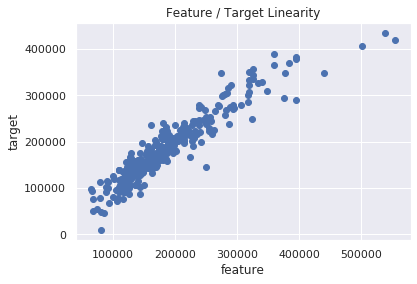

In [193]:
#should look linear 

plt.scatter(y_test, predictions)
plt.xlabel("feature")
plt.ylabel("target")
plt.title('Feature / Target Linearity')
plt.show()

#### Assumption two: the error term should be zero on average

In [194]:

errors = y_test - predictions

print("Mean of the errors in the house costs model is: {}".format(np.mean(errors)))

Mean of the errors in the house costs model is: 971.6905101468815


#### Assumption three: homoscedasticity. Should be centered around zero. 

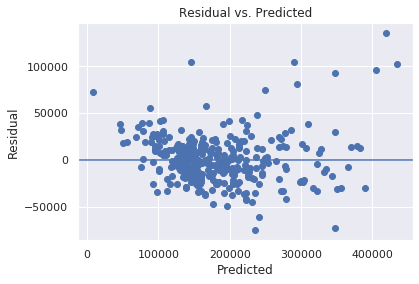

Bartlett test statistic value is 280.073 and p value is 7.24e-63
Levene test statistic value is 142.98 and p value is 5.87e-30


In [195]:
#should be centered around zero
plt.scatter(predictions, errors)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()

#Bartlett and Levene tests: should be above .05
bart_stats = bartlett(predictions, errors)
lev_stats = levene(predictions, errors)

print("Bartlett test statistic value is {0:3g} and p value is {1:.3g}".format(bart_stats[0], bart_stats[1]))
print("Levene test statistic value is {0:3g} and p value is {1:.3g}".format(lev_stats[0], lev_stats[1]))

#### Assumption four: low multicollinearity. Each should be below 5. 

In [196]:
#VIF Method
pd.Series([variance_inflation_factor(X.values, i) for i in range (X.shape[1])], index=X.columns)

#Correlation Matrix Method


/usr/local/lib/python3.6/dist-packages/statsmodels/stats/outliers_influence.py:185: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


const                   2866545.097
mssubclass                   32.915
lotfrontage                   2.001
lotarea                       2.532
overallqual                   4.916
                            ...    
salecondition_AdjLand         1.169
salecondition_Alloca          1.566
salecondition_Family          1.436
salecondition_Normal          3.473
salecondition_Partial        45.608
Length: 167, dtype: float64

#### Assumption five: error terms should be uncorrelated with one another. 

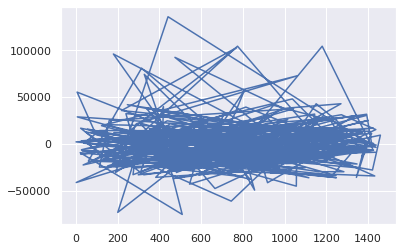

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)


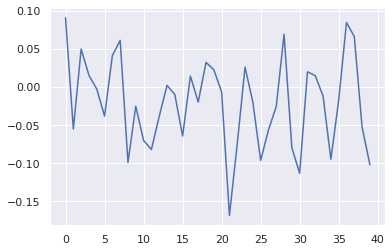

In [197]:
#Should be random and not a pattern.
plt.plot(errors)
plt.show()

#autocorrelation features. Should have low correlation. Not sure cutoff? -.06 to .06 is good
acf_data = acf(errors)

plt.plot(acf_data[1:])
plt.show()

#### Assumption six: features shouldn't be correlated with the errors. Pvalue should be above .05

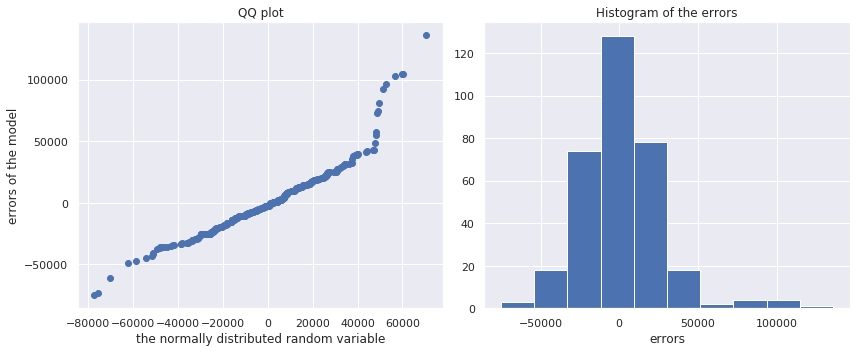

Jarque-Bera test statistics is 328.0948783183638 and p value is 0.0
Normality test statistics is 92.94273686385392 and p value is 6.5726593411922455e-21


In [198]:
rand_nums = np.random.normal(np.mean(errors), np.std(errors), len(errors))

plt.figure(figsize=(12,5))

#we want a straight-ish line
plt.subplot(1,2,1)
plt.scatter(np.sort(rand_nums), np.sort(errors)) # we sort the arrays
plt.xlabel("the normally distributed random variable")
plt.ylabel("errors of the model")
plt.title("QQ plot")

#we want it to look normalish
plt.subplot(1,2,2)
plt.hist(errors)
plt.xlabel("errors")
plt.title("Histogram of the errors")

plt.tight_layout()
plt.show()

#we want low test statistic, high pvalue
jb_stats = jarque_bera(errors)
norm_stats = normaltest(errors)

print("Jarque-Bera test statistics is {0} and p value is {1}".format(jb_stats[0], jb_stats[1]))
print("Normality test statistics is {0} and p value is {1}".format(norm_stats[0], norm_stats[1]))

In [199]:
df3.corr()

,mssubclass,lotfrontage,lotarea,overallqual,overallcond,yearbuilt,yearremodadd,masvnrarea,bsmtfinsf1,bsmtfinsf2,bsmtunfsf,totalbsmtsf,firstflrsf,secondflrsf,lowqualfinsf,grlivarea,bsmtfullbath,bsmthalfbath,fullbath,halfbath,bedroomabvgr,kitchenabvgr,totrmsabvgrd,fireplaces,garageyrblt,garagecars,garagearea,wooddecksf,openporchsf,enclosedporch,threessnporch,screenporch,poolarea,miscval,mosold,yrsold,saleprice,mszoning_FV,mszoning_RH,mszoning_RL,...,bsmtfintype2_Rec,bsmtfintype2_Unf,centralair_Y,electrical_FuseF,electrical_FuseP,electrical_Mix,electrical_SBrkr,kitchenqual_Fa,kitchenqual_Gd,kitchenqual_TA,functional_Maj2,functional_Min1,functional_Min2,functional_Mod,functional_Sev,functional_Typ,garagetype_Attchd,garagetype_Basment,garagetype_BuiltIn,garagetype_CarPort,garagetype_Detchd,garagefinish_RFn,garagefinish_Unf,garagecond_Fa,garagecond_Gd,garagecond_Po,garagecond_TA,saletype_CWD,saletype_Con,saletype_ConLD,saletype_ConLI,saletype_ConLw,saletype_New,saletype_Oth,saletype_WD,salecondition_AdjLand,salecondition_Alloca,salecondition_Family,salecondition_Normal,salecondition_Partial
mssubclass,1.000,-0.358,-0.135,0.048,-0.096,0.055,0.037,0.031,-0.070,-0.075,-0.141,-0.263,-0.259,0.304,0.022,0.067,-0.010,0.001,0.116,0.197,-0.066,0.239,0.011,-0.026,0.079,0.001,-0.075,-0.010,-0.001,-0.022,-0.044,-0.024,0.010,-0.022,-0.020,-0.016,-0.083,0.189,0.019,-0.343,...,-0.053,0.073,-0.097,0.002,0.051,-0.018,0.049,-0.004,0.044,-0.022,-0.032,-0.024,-0.004,-0.006,0.002,-0.009,-0.148,0.046,0.083,0.032,0.091,-0.034,0.011,0.013,-0.006,0.029,-0.013,0.032,0.032,0.109,0.012,0.027,-0.051,-0.024,0.028,-0.004,0.019,0.003,0.044,-0.058
lotfrontage,-0.358,1.000,0.309,0.211,-0.034,0.091,0.068,0.168,0.215,0.056,0.096,0.371,0.409,0.065,0.011,0.360,0.112,-0.013,0.160,0.031,0.245,0.009,0.322,0.228,0.053,0.253,0.322,0.070,0.123,0.016,0.062,0.033,0.183,0.007,0.020,0.005,0.321,-0.099,-0.039,0.327,...,0.053,-0.045,0.076,-0.028,-0.035,-0.012,0.070,-0.018,0.037,-0.117,0.005,-0.016,-0.003,0.018,0.014,0.022,0.198,0.042,0.069,0.027,-0.265,0.115,-0.208,-0.051,-0.022,-0.022,0.059,-0.007,-0.031,0.032,0.015,-0.047,0.124,0.001,-0.088,-0.012,-0.008,0.020,-0.086,0.122
lotarea,-0.135,0.309,1.000,0.090,0.002,-0.005,0.002,0.097,0.209,0.113,-0.014,0.267,0.289,0.049,0.009,0.257,0.161,0.046,0.116,0.007,0.123,-0.013,0.188,0.264,-0.026,0.138,0.168,0.171,0.085,-0.018,0.016,0.039,0.077,0.041,-0.002,-0.012,0.255,-0.088,-0.031,0.198,...,0.107,-0.097,0.034,-0.026,-0.013,-0.005,0.040,-0.018,-0.004,-0.028,-0.003,0.020,0.006,0.062,0.021,-0.028,0.103,-0.003,0.037,0.010,-0.138,0.000,-0.085,-0.026,-0.007,-0.011,0.031,-0.009,-0.004,0.002,0.000,-0.012,0.018,-0.004,-0.001,-0.007,-0.001,-0.013,0.006,0.020
overallqual,0.048,0.211,0.090,1.000,-0.160,0.571,0.550,0.399,0.197,-0.081,0.294,0.508,0.482,0.277,-0.009,0.592,0.083,-0.064,0.578,0.248,0.079,-0.137,0.441,0.377,0.546,0.590,0.529,0.221,0.309,-0.120,0.027,0.047,0.064,-0.031,0.064,-0.015,0.784,0.164,-0.053,0.134,...,-0.105,0.141,0.193,-0.080,-0.021,-0.025,0.205,-0.119,0.389,-0.586,-0.030,-0.101,-0.130,-0.022,-0.005,0.153,0.295,-0.040,0.196,-0.099,-0.388,0.175,-0.505,-0.155,-0.013,-0.060,0.160,0.032,0.037,-0.037,0.022,0.011,0.332,-0.046,-0.235,-0.025,-0.036,-0.040,-0.161,0.327
overallcond,-0.096,-0.034,0.002,-0.160,1.000,-0.422,0.034,-0.139,-0.062,0.031,-0.159,-0.230,-0.144,0.017,0.042,-0.090,-0.075,0.124,-0.211,-0.070,0.026,-0.071,-0.059,-0.033,-0.340,-0.251,-0.205,-0.015,-0.058,0.075,0.026,0.054,-0.003,0.077,-0.011,0.051,-0.108,-0.119,-0.035,-0.058,...,0.038,-0.078,0.057,-0.056,0.033,-0.092,0.040,0.007,-0.027,0.057,-0.107,0.020,-0.004,-0.027,-0.015,0.041,-0.149,-0.019,-0.068,-0.030,0.216,-0.110,0.237,0.025,0.048,-0.021,-0.035,0.034,-0.021,-0.058,0.008,0.008,-0.171,-0.015,0.165,0.010,-0.001,-0.028,0.165,-0.166
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,..

# Model 3

## Ridge Regression

In [227]:
from sklearn.linear_model import RidgeCV
alphas = [4.39, 4.4, 4.5, 4.65, 10,100, 1000, 10000]
rcv = RidgeCV(alphas = alphas) 
rcv.fit(X_train, y_train)
print(rcv.alpha_)

4.39


In [233]:
from sklearn.linear_model import Ridge


# Fitting a ridge regression model. Alpha is the regularization
# parameter (usually called lambda). As alpha gets larger, parameter
# shrinkage grows more pronounced.
ridgeregr = Ridge(alpha=4.39)  
ridgeregr.fit(X_train, y_train)

# We are making predictions here
y_preds_train = ridgeregr.predict(X_train)
y_preds_test = ridgeregr.predict(X_test)

print("R-squared of the model on the training set is: {}".format(ridgeregr.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model on the test set is: {}".format(ridgeregr.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))


R-squared of the model on the training set is: 0.8769558915773081
-----Test set statistics-----
R-squared of the model on the test set is: 0.8713067688522146
Mean absolute error of the prediction is: 18129.98237473161
Mean squared error of the prediction is: 734560915.5950015
Root mean squared error of the prediction is: 27102.784277542436
Mean absolute percentage error of the prediction is: 10.14117781796229


## Lasso Regression

In [237]:
from sklearn.linear_model import Lasso

lassoregr = Lasso(alpha=4.42) 
lassoregr.fit(X_train, y_train)

# We are making predictions here
y_preds_train = lassoregr.predict(X_train)
y_preds_test = lassoregr.predict(X_test)

print("R-squared of the model on the training set is: {}".format(lassoregr.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model on the test set is: {}".format(lassoregr.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))


R-squared of the model on the training set is: 0.8839087251561926
-----Test set statistics-----
R-squared of the model on the test set is: 0.8409437759250924
Mean absolute error of the prediction is: 20341.84874394615
Mean squared error of the prediction is: 907868149.284232
Root mean squared error of the prediction is: 30130.850457367313
Mean absolute percentage error of the prediction is: 11.492753480382573


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8694380344.5542, tolerance: 641140795.139893
  positive)


In [235]:
from sklearn.linear_model import LassoCV
alphas = [4.42, 4.45, 4.5, 4.65, 4.9, 10, 100, 1000, 10000]
lcv = RidgeCV(alphas = alphas) 
lcv.fit(X_train, y_train)
print(lcv.alpha_)

4.42


## Elastic Net

In [242]:
from sklearn.linear_model import ElasticNet

elasticregr = ElasticNet(alpha=1, l1_ratio=.99, max_iter = 208) 
elasticregr.fit(X_train, y_train)

# We are making predictions here
y_preds_train = elasticregr.predict(X_train)
y_preds_test = elasticregr.predict(X_test)

print("R-squared of the model on the training set is: {}".format(elasticregr.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model on the test set is: {}".format(elasticregr.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))


R-squared of the model on the training set is: 0.8709125871231599
-----Test set statistics-----
R-squared of the model on the test set is: 0.8754733382955596
Mean absolute error of the prediction is: 17699.18197262516
Mean squared error of the prediction is: 710778786.2794436
Root mean squared error of the prediction is: 26660.434847906057
Mean absolute percentage error of the prediction is: 9.889000407403048


In [243]:
from sklearn.linear_model import ElasticNetCV
ratios = [.95, .99]
alphas = [1, 2]
ecv = ElasticNetCV(l1_ratio=ratios, n_jobs=-1, alphas = alphas) 

ecv.fit(X_train, y_train)

print(ecv.l1_ratio_)
print(ecv.alpha_)
print(ecv.n_iter_)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 84160766500.32175, tolerance: 459253439.55896604
  tol, rng, random, positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 73605997241.32272, tolerance: 459253439.55896604
  tol, rng, random, positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Dua

0.99
1
208


# Model 4

In [0]:
#Going to hone in for ElasticNet since that was my best model